<font color='royalblue'><h1> ADS 505 Final Project - Team 2</h1>
    <h1> India Housing Rent Prediction</h1>
    <h3>Kiran Singh, Lane Whitmore, Mendelina Lopez</h3>
    </div>
</font>

Github can be found here:

https://github.com/lanewhitmore/Rent_Prediction


A link to the deployed application can be found below:

https://lanewhitmore-rent-prediction-rent-app-eda---whitmore-vd5d0e.streamlitapp.com/

In [37]:
### Package Imports 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import dmba
from dmba import regressionSummary
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import exhaustive_search
from dmba import stepwise_selection, forward_selection, backward_elimination
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error
import pickle
import warnings
import matplotlib.image as mpimg 


warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
rent = pd.read_csv(r'C:/Users/whitm/OneDrive/Documents/GitHub/Rent_Prediction/House_Rent_Dataset.csv')

### Data cleanup will entail splitting dates and addressing categorical variables
rent.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


A first look at the data immediately shows that the dataset requires Floor and Posted On to be extracted during the pre processing steps. Additionally, there are 6 categorical variables that will require either one hot encoding or label encoders to be applied to them. Further discussion about the issues in the data and how they were addressed with be discussed below. 

<font color='royalblue'>
    <h2> Data Pre-Processing</h2>
</font>

<font color='royalblue'>
    <h3> Label Encoding</h3>
</font>

for Area Type, Locality, City, Furnishing, Tenant Preferred, Point of Contact

For the business context to create and deploy an application for consumers to predict rent based off of key characteristics, label encoding will be applied as it is easily deployed. This will have some effects that can be assumed. 

1. Area locality, due to its massive amount of classes, will be become an absolete variable. This will primarily not be a concern as using one hot encoding would add extreme dimension to the dataset. 

2. Using One hot encoding follows standards set for the use of linear regression models or linear models. By electing to use label encoding, we will not be forfeiting performance on all models, but making this decision will deprecate performance on linear models. 

In [4]:
le_areatype = LabelEncoder()
rent['Area Type'] = le_areatype.fit_transform(rent['Area Type'])

In [5]:
le_arealocality = LabelEncoder()
rent['Area Locality'] = le_arealocality.fit_transform(rent['Area Locality'])

In [6]:
le_city = LabelEncoder()
rent['City'] = le_city.fit_transform(rent['City'])

In [7]:
le_furnish = LabelEncoder()
rent['Furnishing Status'] = le_furnish.fit_transform(rent['Furnishing Status'])

In [8]:
le_tenant = LabelEncoder()
rent['Tenant Preferred'] = le_tenant.fit_transform(rent['Tenant Preferred'])

In [9]:
le_contact = LabelEncoder()
rent['Point of Contact'] = le_contact.fit_transform(rent['Point of Contact'])

In [10]:
### Double checking for null values before splitting the data, expecting to see none. 
rent.isnull().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

The label encoding has been successful, and no null variables have been created doing so.

<font color='royalblue'>
    <h3> Train / Test Split</h3>
</font>

In [31]:
### Splitting train and test sets before preprocessing
train, test = train_test_split(rent, test_size = 0.3, random_state = 33)

### Train set predictors & Response
X_train = train.drop('Rent', axis = 1)
y_train = train['Rent']

### Test set predictors & Response
X_test = test.drop('Rent', axis = 1)
y_test = test['Rent']

print('\nTraining Set Length:', len(train))
print('\nTesting Set Length:', len(test))


Training Set Length: 3322

Testing Set Length: 1424


The dataset has been split 70/30 train/test and now has been split between predictors and reponse variables before moving into EDA and preprocessing. This left a sizable amount of the data to train with and fairly evaluate the models.  

<font color='royalblue'>
    <h3> Extracting Floor Information</h3>
</font>


The formulas below extract the numerical values from the Floor predictor creating two predictors that represent the floors the individual is on and the total floors in the building. 
In the UK and India, the ground floor is referred to as the first floor in the U.S. and first floor in the UK and India is the second floor in the U.S..
Therefore, ground floor must be made into 0 and basement has been made into -1.

If, else functions have been implemented that target the first 2 numbers in the string for floor on, and the last two for total floors for the apartment or house.

In [13]:
def clean_flooron(x):
    if 'Gr' in str(x[:2]):
        return 0
    if 'Up' in str(x[:2]):
        return -1
    if 'Lo' in str(x[:2]):
        return -2
    else:
        return str(x[:2])

def clean_floortot(x):
    if 'nd' in str(x[-2:]):
        return 0
    else:
        return str(x[-2:])

In [14]:
### applying formulas to train and test set
X_train['floor on'] = X_train['Floor'].apply(clean_flooron)
X_train['floor total'] = X_train['Floor'].apply(clean_floortot)


X_test['floor on'] = X_test['Floor'].apply(clean_flooron)
X_test['floor total'] = X_test['Floor'].apply(clean_floortot)

X_test.head()

,Posted On,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,floor on,floor total
998,2022-07-09,2,900,10 out of 15,2,11,5,2,1,2,0,10,15
1945,2022-05-14,1,400,Ground out of 3,2,789,0,1,1,1,2,0,3
1679,2022-06-16,2,1050,1 out of 5,2,756,0,1,1,2,2,1,5
2579,2022-05-18,3,200,1 out of 4,1,1505,2,1,0,3,0,1,4
3374,2022-05-06,2,780,1 out of 2,2,1152,1,0,1,2,2,1,2


In [15]:
### Convert obj to datetime
X_train['Posted On'] = pd.to_datetime(X_train['Posted On'])
X_train['month'] = X_train['Posted On'].dt.month
X_train['year'] = X_train['Posted On'].dt.year
X_train['DOW'] = X_train['Posted On'].dt.dayofweek

X_test['Posted On'] = pd.to_datetime(X_test['Posted On'])
X_test['month'] = X_test['Posted On'].dt.month
X_test['DOW'] = X_test['Posted On'].dt.dayofweek
X_test['year'] = X_test['Posted On'].dt.year

X_train.head()

,Posted On,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,floor on,floor total,month,year,DOW
1698,2022-06-04,2,1000,3 out of 4,2,322,0,1,1,2,2,3,4,6,2022,5
3924,2022-05-10,2,200,Ground out of 1,1,460,3,2,0,2,2,0,1,5,2022,1
4375,2022-05-24,2,1200,2 out of 2,2,255,3,2,0,2,2,2,2,5,2022,1
3910,2022-06-10,2,1140,3 out of 4,2,1412,3,1,1,2,2,3,4,6,2022,4
3864,2022-05-16,2,1000,2 out of 3,2,423,1,2,1,2,2,2,3,5,2022,0


The Posted On predictor has been adjusted to represent the month posted, the year posted and the day of the week the listing was posted. In this dataset, all of the listings were posted in the year 2022, this feature will subsequently be dropped prior to modeling. 

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3322 entries, 1698 to 2439
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Posted On          3322 non-null   datetime64[ns]
 1   BHK                3322 non-null   int64         
 2   Size               3322 non-null   int64         
 3   Floor              3322 non-null   object        
 4   Area Type          3322 non-null   int32         
 5   Area Locality      3322 non-null   int32         
 6   City               3322 non-null   int32         
 7   Furnishing Status  3322 non-null   int32         
 8   Tenant Preferred   3322 non-null   int32         
 9   Bathroom           3322 non-null   int64         
 10  Point of Contact   3322 non-null   int32         
 11  floor on           3322 non-null   object        
 12  floor total        3322 non-null   object        
 13  month              3322 non-null   int64         
 14  year 

In [17]:
X_train[['floor on', 'floor total']] = X_train[['floor on', 'floor total']].astype(int)
X_test[['floor on', 'floor total']] = X_test[['floor on', 'floor total']].astype(int)

The new floor on and floor total predictors need to be converted from object string to integer now that they have been extracted from Floor.

<font color='darkgreen'>
    <h2> Exploratory Data Analysis </h2>
</font>

<font color='darkgreen'>
    <h4> Observing the Value Count of Categorical Variables</h4> 
</font>

In [18]:
### Year will be a zero variance variable and therefore can be dropped
X_train[['year']].value_counts()

year
2022    3322
dtype: int64

Again, year will be dropped as it is zero variance. 

In [19]:
X_train[['Area Type']].value_counts()

Area Type
2            1688
1            1632
0               2
dtype: int64

0 class will be kept in for consumers to be able to pick the class during app deployment. 

In [20]:
X_train[['City']].value_counts()

City
5       707
1       624
0       613
3       593
2       424
4       361
dtype: int64

In [21]:
X_train[['Tenant Preferred']].value_counts()

Tenant Preferred
1                   2392
0                    586
2                    344
dtype: int64

In [32]:
X_train[['Point of Contact']].value_counts()

Point of Contact
2                   2226
0                   1096
dtype: int64

Within the test set there is a 1 class represented by a single variable, for contact Construction. This will be kept in the dataset to represent unseen future instances of this post deployment. 

In [33]:
X_train[['Furnishing Status']].value_counts()

Furnishing Status
1                    1560
2                    1287
0                     475
dtype: int64

<font color='darkgreen'>
    <h4> Histogram for Continuous Variables</h4>
</font>

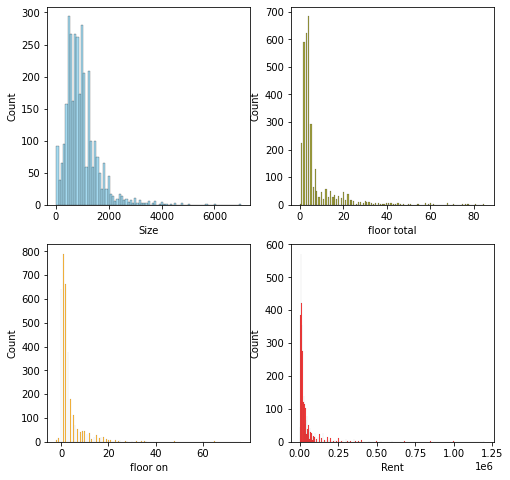

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.histplot(X_train["Size"] , color="skyblue", ax=axes[0,0])
sns.histplot(X_train["floor total"] , color="olive", ax=axes[0,1])
sns.histplot(X_train["floor on"] , color="orange", ax=axes[1,0])
sns.histplot(y_train , color="red", ax=axes[1,1])
plt.show()

There is a left skew on all continuous predictors and the response variable rent. This could potentially limit models that assume normal distribution such as logistic regression, linear regression, or sigmoid function. This will likely lead to ensemble methods that implement the use of decision trees rather than linear formulas. 

<font color='darkgreen'>
    <h4> Correlation Matrix </h4>
</font>

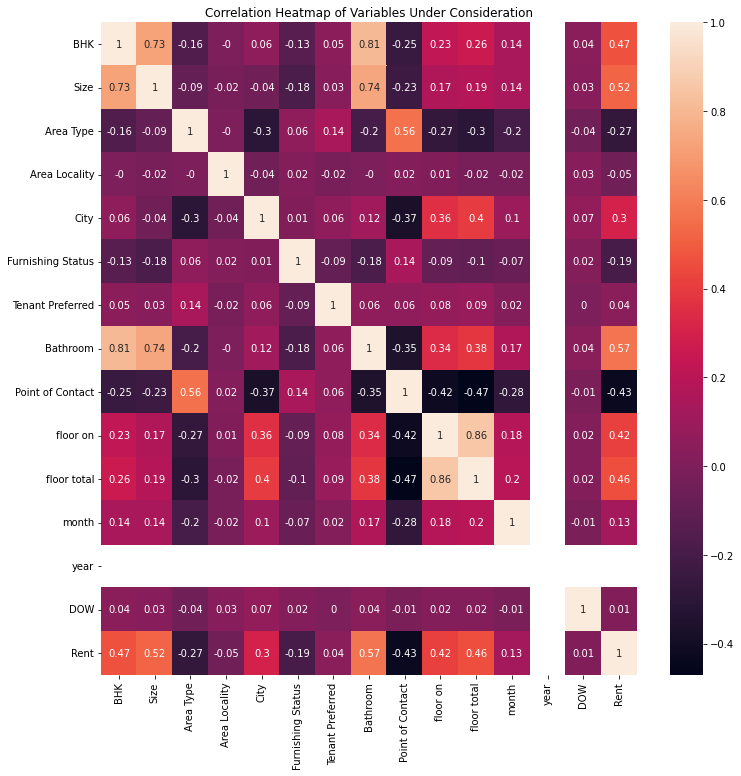

In [24]:
matrix = pd.concat([X_train, y_train], axis = 1).corr().round(2)
plt.figure(figsize=(12,12))
sns.heatmap(matrix, annot=True)
plt.title('Correlation Heatmap of Variables Under Consideration')
plt.show()

Looking at our confusion matrix, size, bedrooms, and bathrooms all cary a high correlation to one another. Incidentally, they also correlate the highest with the response variable rent. Floor on also highly correlates to floor total. Likely, floor total will make it into the subset for model construction because total floor is more likely to identify expensive homes with low floor counts in addition to finding that tall buildings with massive amount of aparments will be a little cheaper. This can be more logically derived than the use of floor on. 

<font color='darkgreen'>
    <h4> Scatterplots Exploring Relationships </h4>
</font>

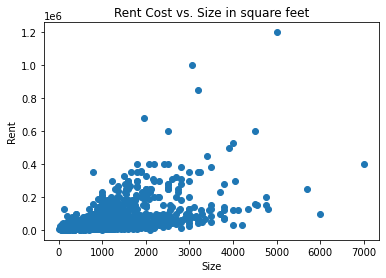

In [25]:
plt.scatter(x = X_train['Size'], y = y_train)
plt.title('Rent Cost vs. Size in square feet')
plt.xlabel('Size')
plt.ylabel('Rent')
plt.show()

Size and Rent do show a slight relationship that moves to more costly renting options when the size of the building increases. 

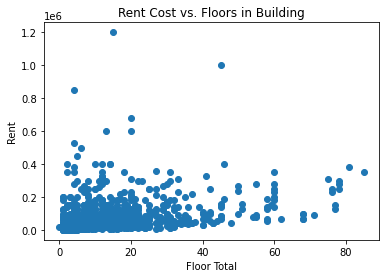

In [26]:
plt.scatter(x = X_train['floor total'], y = y_train)
plt.title('Rent Cost vs. Floors in Building')
plt.xlabel('Floor Total')
plt.ylabel('Rent')
plt.show()

Floor total and rent cost are less associated. There are slightly higher rent costs among lower floors, but there are also more low cost listings as well. 

In [27]:
Xmod_train = X_train.drop(['Posted On','Floor','year'], axis = 1)

Xmod_test = X_test.drop(['Posted On','Floor','year'], axis = 1)

Xmod_train.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,floor on,floor total,month,DOW
1698,2,1000,2,322,0,1,1,2,2,3,4,6,5
3924,2,200,1,460,3,2,0,2,2,0,1,5,1
4375,2,1200,2,255,3,2,0,2,2,2,2,5,1
3910,2,1140,2,1412,3,1,1,2,2,3,4,6,4
3864,2,1000,2,423,1,2,1,2,2,2,3,5,0


Obsolete variables have been dropped. Full training set. 

<font color='darkgreen'>
    <h3> Feature Extraction Using Linear Model and Stepwise Selection </h3>
</font>

In [31]:
### train model is built to iterate through the variables when performing stepwise regression
def train_model(variables):
    if len(variables) == 0:
        return None
    ### Building linear regression
    Model = LinearRegression()
    Model.fit(Xmod_train[variables], y_train)
    ### Returning the model fit with X amount of variables
    return Model

### Score model calculates the AIC of the models in order to choose the best variables based off of AIC
def score_model(Model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), Model, df = 1)
    return AIC_score(y_train, Model.predict(Xmod_train[variables]), Model)

In [32]:
### Using Stepwise selection to extract the best variables
best_model, best_variables = stepwise_selection(Xmod_train.columns, train_model, score_model,
                                               verbose = True)
print(best_variables)

Variables: BHK, Size, Area Type, Area Locality, City, Furnishing Status, Tenant Preferred, Bathroom, Point of Contact, floor on, floor total, month, DOW
Start: score=82714.61, constant
Step: score=81423.82, add Bathroom
Step: score=81058.38, add floor total
Step: score=80869.84, add Size
Step: score=80687.18, add City
Step: score=80609.16, add Point of Contact
Step: score=80583.89, add Furnishing Status
Step: score=80571.13, add month
Step: score=80568.30, add Area Locality
Step: score=80565.19, add floor on
Step: score=80563.48, add DOW
Step: score=80561.58, add Area Type
Step: score=80561.58, unchanged None
['Bathroom', 'floor total', 'Size', 'City', 'Point of Contact', 'Furnishing Status', 'month', 'Area Locality', 'floor on', 'DOW', 'Area Type']


In [33]:
sub_train = Xmod_train[['Bathroom', 'floor total', 'Size', 'City', 'Point of Contact', 
                        'Furnishing Status', 'month', 'Area Locality', 'floor on', 'DOW', 'Area Type']]

sub_test = Xmod_test[['Bathroom', 'floor total', 'Size', 'City', 'Point of Contact', 
                      'Furnishing Status', 'month', 'Area Locality', 'floor on', 'DOW', 'Area Type']]

Although after encoding the categorical data linear models would be less telling of our potential performance. Step wise selection here has been used to be informative of the Random Forest Importances and how the subset should be split for comparison to the full dataset across models. While this subset will not be used, it can still be informative to compare results. 

<font color='darkred'>
    <h2> Model Construction </h2>
</font>

The models below will be tuned using cross validation of k folds = 5. Due to the computation costs of some of the models such as SVM Regressor, 5 folds has been elected instead 10 to reduce training time and the computation cost. 

The models below will also be separated by full dataset and the subset taken using the context of the stepwise selction and Random Forest Regressor importance values in addition to knowledge gained working with the data. 

Additionally, the models will be evaluated using MAE and R^2. MAE will evaluate the average error in Indian rupee made by predictions using the model by comparing the prediction to the known value. R^2 represents the amount of variance that the model can predictable cover. 

<font color='darkred'>
    <h3> Random Forest Regressor </h3>
</font>

<font color='darkred'>
    <h3> Full Dataset </h3>
</font>

<font color='darkred'>
    <h4> Model Tuning </h4>
</font>

In [34]:
rf_param_grid = {
    'max_depth': [5,10,15,20],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [10,20,30,40,50]
}
### Using GridSearch Cross Validation to identify best parameters
rf_search = GridSearchCV(RandomForestRegressor(random_state = 33), rf_param_grid, cv = 5, 
                          n_jobs = -1, return_train_score = True)

rf_search.fit(Xmod_train, y_train)
print('\nBest Score:', rf_search.best_score_)
print('\nGeneral Parameters:', rf_search.best_params_)


Best Score: 0.696100449223651

General Parameters: {'max_depth': 15, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [35]:
rrf_param_grid = {
    'max_depth': [16,17,18,19,20,21,22,23,24],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [17,18,19,20,21,22,23]
}
### Using GridSearch Cross Validation to identify best parameters
rrf_search = GridSearchCV(RandomForestRegressor(random_state = 33), rrf_param_grid, cv = 5, 
                          n_jobs = -1, return_train_score = True)

rrf_search.fit(Xmod_train, y_train)
print('\nBest Score:', rrf_search.best_score_)
print('\nGeneral Parameters:', rrf_search.best_params_)


Best Score: 0.6960652842494689

General Parameters: {'max_depth': 17, 'min_impurity_decrease': 0, 'min_samples_split': 21}


<font color='darkred'>
    <h4> Full Dataset RF Model </h4>
</font>

In [28]:
### Building Random Forest Model based off of parameters
rf = RandomForestRegressor(max_depth = 16, min_impurity_decrease = 0, 
                            min_samples_split = 19, random_state = 33).fit(Xmod_train, y_train)

### rsquared score
regressionSummary(y_test, rf.predict(Xmod_test))
print('\n')
print('r2 Score:', r2_score(y_test, rf.predict(Xmod_test)))


Regression statistics

                      Mean Error (ME) : 2785.6451
       Root Mean Squared Error (RMSE) : 95086.5740
            Mean Absolute Error (MAE) : 12939.4020
          Mean Percentage Error (MPE) : -19.1573
Mean Absolute Percentage Error (MAPE) : 36.3018


r2 Score: 0.21022997767745022


The model covers about 21% of the variance in the data. For context, an MAE of 12,939 rupees would be equivalent to about 150 USD. The average rent value within the training set is about 35,000 rupees or around 420 USD. Meaning on average, the model is missing predictions by about 36% as the MAPE shows above. Hopefully, using the variable importance from this model to subset the data will lead to better results. 

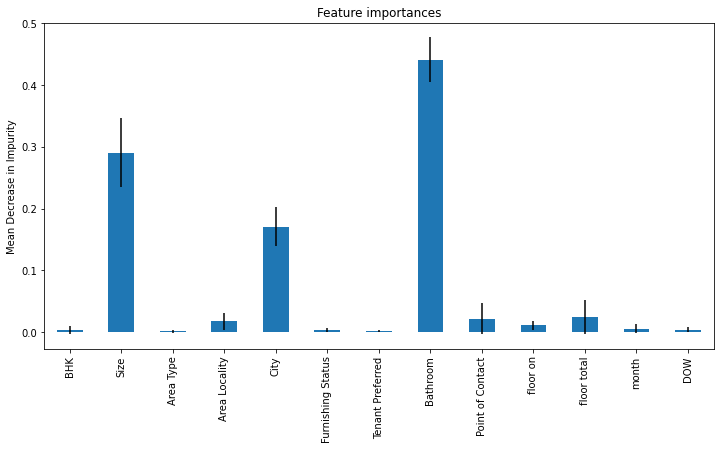

In [37]:
### Looking at the most important features for selection
feature_names = Xmod_train.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean Decrease in Impurity")
plt.show()

Our most important variables are clearly Size, City, and Bathrooms. Folowing closely is floor total and Point of contact. only one of floor will be selected for the subset. Additionally, BHK will be carried over knowing that the rooms of a home is vital for making evaluations of homes. This leaves the 6 variables below to create the subset models. 

<font color='darkred'>
    <h4> Creating the Final Subset </h4>
</font>

In [170]:
#### Extracting the 6 most important features for a subset

sub_X_test = Xmod_test[['Size','City','Bathroom','floor total','Point of Contact','BHK']]
sub_X_train = Xmod_train[['Size','City','Bathroom','floor total','Point of Contact','BHK']]

<font color='darkred'>
    <h3> Subset Data Modeling </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [39]:
srf_param_grid = {
    'max_depth': [5,10,15,20],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [10,20,30,40,50]
}
### Using GridSearch Cross Validation to identify best parameters
srf_search = GridSearchCV(RandomForestRegressor(random_state = 33), srf_param_grid, cv = 5, 
                          n_jobs = -1, return_train_score = True)

srf_search.fit(sub_X_train, y_train)
print('\nBest Score:', srf_search.best_score_)
print('\nGeneral Parameters:', srf_search.best_params_)


Best Score: 0.6978536254164498

General Parameters: {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [40]:
srrf_param_grid = {
    'max_depth': [5,6,7,8,9,10,11,12,13,14,15],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [25,26,27,28,29,30,31,32,33,34]
}
### Using GridSearch Cross Validation to identify best parameters
srrf_search = GridSearchCV(RandomForestRegressor(random_state = 33), srrf_param_grid, cv = 5, 
                           n_jobs = -1, return_train_score = True)

srrf_search.fit(sub_X_train, y_train)
print('\nBest Score:', srrf_search.best_score_)
print('\nGeneral Parameters:', srrf_search.best_params_)


Best Score: 0.6961180629553694

General Parameters: {'max_depth': 15, 'min_impurity_decrease': 0, 'min_samples_split': 25}


<font color='darkred'>
    <h4> Sub Dataset Final Model </h4>
</font>

In [171]:
### Building Random Forest Model based off of parameters
sub_rf = RandomForestRegressor(max_depth = 11, min_impurity_decrease = 0, 
                               min_samples_split = 26, random_state = 33).fit(sub_X_train, y_train)

### rsquared score
regressionSummary(y_test, sub_rf.predict(sub_X_test))
print('\n')
print('r2 Score:', r2_score(y_test, sub_rf.predict(sub_X_test)))


Regression statistics

                      Mean Error (ME) : 3167.5681
       Root Mean Squared Error (RMSE) : 94827.0205
            Mean Absolute Error (MAE) : 12817.0340
          Mean Percentage Error (MPE) : -17.8323
Mean Absolute Percentage Error (MAPE) : 35.5977


r2 Score: 0.21453569116937032


Subsetting the dataset proved to give a slight uptick in r^2 and a slight decrease in MAE and MAPE. MPE is showing that model is under predicting the true cost of rent more often than over predicting. Which, could potentially be a positive compared to over prediction. Going forward, the subset will continued to be compared throughout our models. 

<font color='darkred'>
    <h3> MLP Regressor </h3>
</font>

<font color='darkred'>
    <h3> Full Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [193]:
### Initial gridsearch looking for activation // solver tune
mlp_param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam','sgd'], 
    'learning_rate_init': [0.01, 0.05, 0.075, 0.1]
}

mlp_search = GridSearchCV(MLPRegressor(random_state = 33, batch_size = 64, max_iter = 2000), mlp_param_grid, 
                          cv = 5, n_jobs = 12)

mlp_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', mlp_search.best_params_)


General Parameters: {'activation': 'relu', 'learning_rate_init': 0.01, 'solver': 'adam'}


In [43]:
### GridSearching hyperparameters
rmlp_param_grid = {
    'hidden_layer_sizes': [20, 30, 40, 50, 60, 70, 80, 90, 100],
    'alpha': [0.0001, 0.001, 0.005, 0.01, 0.1]
}

rmlp_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', 
                                       learning_rate_init = 0.01, batch_size = 64, 
                                       max_iter = 2000, random_state = 33), 
                           rmlp_param_grid, cv = 5, n_jobs = 12)

rmlp_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', rmlp_search.best_params_)


General Parameters: {'alpha': 0.001, 'hidden_layer_sizes': 80}


In [46]:
### Final GridSearch for minute adjustments
cls_param_grid = {
    'hidden_layer_sizes': [78,79,80,81,82,83,84,85,86,87,88,89]
}

cls_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', alpha = 0.001, 
                                       learning_rate_init = 0.01, batch_size = 64, 
                                       max_iter = 2000, random_state = 33), 
                          cls_param_grid, cv = 5, n_jobs = 12)

cls_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', cls_search.best_params_)


General Parameters: {'hidden_layer_sizes': 85}


<font color='darkred'>
    <h4> Full Dataset Final MLP </h4>
</font>

In [172]:
### Building the final subset predictor model
mlp = MLPRegressor(activation = 'relu', solver = 'adam', 
                   alpha = 0.01, hidden_layer_sizes = 85, 
                   batch_size = 64, max_iter = 2000, 
                   random_state = 33).fit(Xmod_train, y_train)


print('\nr2 Score:', r2_score(y_test, mlp.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, mlp.predict(Xmod_test))


r2 Score: 0.17479721850779262



Regression statistics

                      Mean Error (ME) : 3371.7244
       Root Mean Squared Error (RMSE) : 97196.1850
            Mean Absolute Error (MAE) : 18542.0700
          Mean Percentage Error (MPE) : -13.2667
Mean Absolute Percentage Error (MAPE) : 69.3974


Across the board the MLP regressor has shown to be a worse predictor than the random forest regressor. Although, the model does make more over predictions than either of the previous models, looking at its MPE. Nearly 70% MAPE versus 35% on the previous model makes the model not as worth considering. The subset will still be attempted. 

<font color='darkred'>
    <h3> Subset Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [194]:
### Initial gridsearch looking for activation // solver tune
smlp_param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam','sgd'], 
    'learning_rate_init': [0.01, 0.05, 0.075, 0.1]
}

smlp_search = GridSearchCV(MLPRegressor(random_state = 33, batch_size = 64, max_iter = 2000), smlp_param_grid, 
                          cv = 10, n_jobs = 12)

smlp_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', smlp_search.best_params_)


General Parameters: {'activation': 'relu', 'learning_rate_init': 0.1, 'solver': 'adam'}


In [33]:
### GridSearching hyperparameters
srmlp_param_grid = {
    'hidden_layer_sizes': [20, 30, 40, 50, 60, 70, 80, 90, 100],
    'alpha': [0.0001, 0.001, 0.005, 0.01, 0.1]
}

srmlp_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', 
                                       learning_rate_init = 0.1, batch_size = 64, 
                                       max_iter = 2000, random_state = 33), 
                           srmlp_param_grid, cv = 5, n_jobs = 12)

srmlp_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', srmlp_search.best_params_)


General Parameters: {'alpha': 0.001, 'hidden_layer_sizes': 100}


In [34]:
### Final GridSearch for minute adjustments
scls_param_grid = {
    'hidden_layer_sizes': [95,96,97,98,99,100,101,102,103,104]
}

scls_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', alpha = 0.001, 
                                        learning_rate_init = 0.1, batch_size = 64, 
                                        max_iter = 2000, random_state = 33), 
                           scls_param_grid, cv = 5, n_jobs = 12)

scls_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', scls_search.best_params_)


General Parameters: {'hidden_layer_sizes': 100}


<font color='darkred'>
    <h4> sub Dataset Final MLP </h4>
</font>

In [173]:
### Building the final subset predictor model
sub_mlp = MLPRegressor(activation = 'relu', solver = 'adam', 
                       alpha = 0.001, hidden_layer_sizes = 100, 
                       batch_size = 64, max_iter = 2000, learning_rate_init = 0.1,
                       random_state = 33).fit(sub_X_train, y_train)


print('\nr2 Score:', r2_score(y_test, sub_mlp.predict(sub_X_test)))
print('\n')
regressionSummary(y_test, sub_mlp.predict(sub_X_test))


r2 Score: 0.16412378906241654



Regression statistics

                      Mean Error (ME) : -2484.3584
       Root Mean Squared Error (RMSE) : 97822.7483
            Mean Absolute Error (MAE) : 21089.1606
          Mean Percentage Error (MPE) : -39.8958
Mean Absolute Percentage Error (MAPE) : 74.1159


Moving to the subset data decreased the already bad metrics of the previous MLP Regressor.

<font color='darkred'>
    <h3> Logistic Regression </h3>
</font>

<font color='darkred'>
    <h3> Full Dataset </h3>
</font>

In [48]:
logreg_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', 
                                 max_iter = 500, random_state = 33)
logreg_full.fit(Xmod_train, y_train)

print('\nr2 Score:', r2_score(y_test, logreg_full.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, logreg_full.predict(Xmod_test))


r2 Score: 0.015368329969471684



Regression statistics

                      Mean Error (ME) : 4044.6390
       Root Mean Squared Error (RMSE) : 106170.9681
            Mean Absolute Error (MAE) : 21037.6461
          Mean Percentage Error (MPE) : -14.3773
Mean Absolute Percentage Error (MAPE) : 51.6336


Although the r2 is lower with the logistic regression model compared to the previous MLP, the MAPE showed improvement reducing to nearly 51%. Although the MAE is equally as bad as the previous MLP and nowhere near the random forest metrics. 

<font color='darkred'>
    <h3> Subset Dataset </h3>
</font>

In [174]:
logreg_sub = LogisticRegression(penalty = "l2", C = 1e42, solver='liblinear',
                                max_iter = 500, random_state = 33)
                                
logreg_sub.fit(sub_X_train, y_train)

print('\nr2 Score:', r2_score(y_test, logreg_sub.predict(sub_X_test)))
print('\n')
regressionSummary(y_test, logreg_sub.predict(sub_X_test))


r2 Score: -0.006301046995255133



Regression statistics

                      Mean Error (ME) : 11385.4874
       Root Mean Squared Error (RMSE) : 107332.8941
            Mean Absolute Error (MAE) : 19568.0955
          Mean Percentage Error (MPE) : -12.1073
Mean Absolute Percentage Error (MAPE) : 54.0479


The subset dataset did improve the MAE, but nearly every other metric depreciated from the full set. 

<font color='darkred'>
    <h3> XGBoost </h3>
</font>

<font color='darkred'>
    <h3> Full Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [50]:
xgb_param_grid = {
    'eta': [0, 0.25, 0.5, 0.75],
    'max_depth': [10, 15, 20],
    'lambda': [0,1,2,5]
}

xgb_search = GridSearchCV(xgb.XGBRegressor(random_state = 33, verbosity = 0), xgb_param_grid, 
                          cv = 5, n_jobs = 12)

xgb_search.fit(Xmod_train, y_train)
print('\nBest Score:', xgb_search.best_score_)
print('\nGeneral Parameters:', xgb_search.best_params_)


Best Score: 0.6667065870992258

General Parameters: {'eta': 0.25, 'lambda': 2, 'max_depth': 10}


In [51]:
rxgb_param_grid = {
    'eta': [0,0.15,0.20,0.25],
    'max_depth': [2,3,4,5,6,7,8,9,10],
    'lambda': [1,2,3,4]
}

rxgb_search = GridSearchCV(xgb.XGBRegressor(random_state = 33, verbosity = 0), rxgb_param_grid, 
                          cv = 5, n_jobs = 12)

rxgb_search.fit(Xmod_train, y_train)
print('\nBest Score:', rxgb_search.best_score_)
print('\nGeneral Parameters:', rxgb_search.best_params_)


Best Score: 0.698604400259686

General Parameters: {'eta': 0.2, 'lambda': 3, 'max_depth': 6}


<font color='darkred'>
    <h4> Full Dataset Final XGBoost </h4>
</font>

In [52]:
xgbr_full = xgb.XGBRegressor(eta = 0.2, max_depth = 6, reg_lambda = 3, 
                             verbosity = 0, random_state = 33).fit(Xmod_train, y_train)


print('\nr2 Score:', r2_score(y_test, xgbr_full.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, xgbr_full.predict(Xmod_test))


r2 Score: 0.20954762926087356



Regression statistics

                      Mean Error (ME) : 2923.2469
       Root Mean Squared Error (RMSE) : 95127.6417
            Mean Absolute Error (MAE) : 12763.1410
          Mean Percentage Error (MPE) : -16.9179
Mean Absolute Percentage Error (MAPE) : 36.3374


The XGBoost performed similarly to the Random Forest metric wise. The MAPE is at an acceptable margin below 40% and the MAE is about at the $150 USD mark that is preferable compared to the LR and MLP models. The XGBoost will be considered in addition to the Random Forest moving forward. 

<font color='darkred'>
    <h3> Subset Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [53]:
sxgb_param_grid = {
    'eta': [0, 0.25, 0.5, 0.75],
    'max_depth': [10, 15, 20, 25, 30],
    'lambda': [1,2,3,4]
}

sxgb_search = GridSearchCV(xgb.XGBRegressor(random_state = 33, verbosity = 0), sxgb_param_grid, 
                           cv = 5, n_jobs = 12)

sxgb_search.fit(sub_X_train, y_train)
print('\nBest Score:', sxgb_search.best_score_)
print('\nGeneral Parameters:', sxgb_search.best_params_)


Best Score: 0.6032751956184577

General Parameters: {'eta': 0.75, 'lambda': 4, 'max_depth': 20}


In [48]:
rsxgb_param_grid = {
    'eta': [0.7,0.75,0.8,0.9],
    'max_depth': [22,23,24,25,26,27,28,29,30],
    'lambda': [4,5,6]
}

rsxgb_search = GridSearchCV(xgb.XGBRegressor(random_state = 33, verbosity = 0), rsxgb_param_grid, 
                            cv = 5, n_jobs = 12)

rsxgb_search.fit(sub_X_train, y_train)
print('\nBest Score:', rsxgb_search.best_score_)
print('\nGeneral Parameters:', rsxgb_search.best_params_)


Best Score: 0.6165273457400516

General Parameters: {'eta': 0.9, 'lambda': 5, 'max_depth': 26}


<font color='darkred'>
    <h4> Subset Dataset Final XGboost</h4>
</font>

In [175]:
xgbr_sub = xgb.XGBRegressor(eta = 0.9, reg_lambda = 5, max_depth = 26, 
                            verbosity = 0, random_state = 33).fit(sub_X_train, y_train)


print('\nr2 Score:', r2_score(y_test, xgbr_sub.predict(sub_X_test)))
print('\n')
regressionSummary(y_test, xgbr_sub.predict(sub_X_test))


r2 Score: 0.2008031192925832



Regression statistics

                      Mean Error (ME) : 3030.0501
       Root Mean Squared Error (RMSE) : 95652.3771
            Mean Absolute Error (MAE) : 14582.8195
          Mean Percentage Error (MPE) : -16.4930
Mean Absolute Percentage Error (MAPE) : 41.0158


Subsetting the XGboost did reduce the metric performance as the MAPE climbed about the 40% threshold and MAE climbed to an error of $160 each prediction. 

<font color='darkred'>
    <h3> SVM Regression </h3>
</font>

<font color='darkred'>
    <h4> Feature Scaling For SVM </h4>
</font>

In [177]:
scl_col = Xmod_train.drop(['City','Tenant Preferred', 'Area Type', 'Point of Contact'], axis = 1).columns
scaling = StandardScaler()
Xscale_train = pd.concat([Xmod_train[['City','Tenant Preferred','Area Type','Point of Contact']],
                         pd.DataFrame(scaling.fit_transform(Xmod_train.drop(['City',
                                                                             'Tenant Preferred', 
                                                                             'Area Type', 
                                                                             'Point of Contact'], axis = 1)), columns = scl_col, index = Xmod_train.index)], axis = 1)

Xscale_test = pd.concat([Xmod_test[['City','Tenant Preferred','Area Type','Point of Contact']],
                         pd.DataFrame(scaling.fit_transform(Xmod_test.drop(['City',
                                                                             'Tenant Preferred', 
                                                                             'Area Type', 
                                                                             'Point of Contact'], axis = 1)), columns = scl_col, index = Xmod_test.index)], axis = 1)


sbscl_col = sub_X_train.drop(['City','Point of Contact'], axis = 1).columns
subscale = StandardScaler()
sub_Xscale_train = pd.concat([sub_X_train[['City','Point of Contact']], 
                              pd.DataFrame(subscale.fit_transform(sub_X_train.drop(['City','Point of Contact'], axis = 1)), 
                                           columns = sbscl_col , index = sub_X_train.index)], axis = 1)

sub_Xscale_test = pd.concat([sub_X_test[['City','Point of Contact']], 
                             pd.DataFrame(subscale.transform(sub_X_test.drop(['City','Point of Contact'], axis = 1)), 
                                          columns = sbscl_col , index = sub_X_test.index)], axis = 1)

The SVM model requires model scaling to perform optimally. There are categorical values encoded that should not be scaled as they are categorical. Those are dropped, the continuous values are scaled, and then are recatenated back to the categorical values. This is then repeated for the 6 variable subset. 

<font color='darkred'>
    <h3> Full Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [103]:
svm_param_grid = {
    'tol': [1e-3, 1e-2, 0.1, 1],
    'C': [1, 2, 5, 100, 500, 1000],
    'epsilon': [0.001,0.01,0.1,1]
}

svmp_search = GridSearchCV(SVR(kernel  = 'poly'), svm_param_grid, 
                           cv = 5, n_jobs = 12)

svmr_search = GridSearchCV(SVR(kernel  = 'rbf'), svm_param_grid, 
                           cv = 5, n_jobs = 12)

svms_search = GridSearchCV(SVR(kernel  = 'sigmoid'), svm_param_grid, 
                           cv = 5, n_jobs = 12)

svmp_search.fit(Xscale_train, y_train)
svmr_search.fit(Xscale_train, y_train)
svms_search.fit(Xscale_train, y_train)
print('\nGeneral Parameters:', svmp_search.best_params_)
print('\nBest Score:', svmp_search.best_score_)
print('\nGeneral Parameters:', svmr_search.best_params_)
print('\nBest Score:', svmr_search.best_score_)
print('\nGeneral Parameters:', svms_search.best_params_)
print('\nBest Score:', svms_search.best_score_)


General Parameters: {'C': 1000, 'epsilon': 1, 'tol': 1}

Best Score: 0.5905960414159196

General Parameters: {'C': 1000, 'epsilon': 1, 'tol': 1}

Best Score: 0.28788869764875924

General Parameters: {'C': 100, 'epsilon': 0.001, 'tol': 1}

Best Score: 0.07461647095990895


In [122]:
rsvm_param_grid = {
    'tol': [1,2,3,4,5],
    'C': [10000,15000,19000,20000,21000],
    'epsilon': [7,8,9,10]
}

rsvmp_search = GridSearchCV(SVR(kernel  = 'poly'), rsvm_param_grid, 
                            cv = 5, n_jobs = 12)

rsvmp_search.fit(Xscale_train, y_train)
print('\nGeneral Parameters:', rsvmp_search.best_params_)
print('\nBest Score:', rsvmp_search.best_score_)


General Parameters: {'C': 19000, 'epsilon': 8, 'tol': 5}

Best Score: 0.6455180902410703


<font color='darkred'>
    <h4> Full Dataset Final SVM </h4>
</font>

In [123]:
svm = SVR(tol = 5, C = 19000, epsilon = 8).fit(Xscale_train, y_train)

print('\nr2 Score:', r2_score(y_test, svm.predict(Xscale_test)))
print('\n')
regressionSummary(y_test, svm.predict(Xscale_test))



r2 Score: 0.171027218349858



Regression statistics

                      Mean Error (ME) : 7381.3776
       Root Mean Squared Error (RMSE) : 97417.9560
            Mean Absolute Error (MAE) : 14022.8706
          Mean Percentage Error (MPE) : -10.4785
Mean Absolute Percentage Error (MAPE) : 33.5493


The final tune of the SVM revealed the lowest MPE and MAPE so far, but r2 and MAE both suffered. As the MAE is more directly the error missed, due to it using the residuals. Yet, this may  point out that the model is performing well on most moderate data points, then largely missing the outliers on the low or high side, in this instance the assumption would be the high side as Rent is left skewed at the MPE is less negative than previous models. 

<font color='darkred'>
    <h3> Subset Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [94]:
ssvm_param_grid = {
    'tol': [1e-3, 1e-2, 0.1, 1],
    'C': [20,30,40,50,60],
    'epsilon': [0.001,0.01,0.1,1]
}

ssvmp_search = GridSearchCV(SVR(kernel  = 'poly'), ssvm_param_grid, 
                            cv = 5, n_jobs = 12)

ssvmr_search = GridSearchCV(SVR(kernel  = 'rbf'), ssvm_param_grid, 
                            cv = 5, n_jobs = 12)

ssvms_search = GridSearchCV(SVR(kernel  = 'sigmoid'), ssvm_param_grid, 
                            cv = 5, n_jobs = 12)

ssvmp_search.fit(sub_Xscale_train, y_train)
ssvmr_search.fit(sub_Xscale_train, y_train)
ssvms_search.fit(sub_Xscale_train, y_train)
print('\nGeneral Parameters:', ssvmp_search.best_params_)
print('\nBest Score:', ssvmp_search.best_score_)
print('\nGeneral Parameters:', ssvmr_search.best_params_)
print('\nBest Score:', ssvmr_search.best_score_)
print('\nGeneral Parameters:', ssvms_search.best_params_)
print('\nBest Score:', ssvms_search.best_score_)


General Parameters: {'C': 60, 'epsilon': 1, 'tol': 1}

Best Score: 0.4982859426066472

General Parameters: {'C': 60, 'epsilon': 1, 'tol': 0.1}

Best Score: 0.0457954665956787

General Parameters: {'C': 50, 'epsilon': 1, 'tol': 1}

Best Score: -0.011678406811354191


In [98]:
rssvm_param_grid = {
    'tol': [0.5,1,1.5,2],
    'C': [110,130,170,200,250,500,1000,2000],
    'epsilon': [4,5,6,7,8,9,10]
}

rssvmp_search = GridSearchCV(SVR(kernel  = 'poly'), rssvm_param_grid, 
                             cv = 5, n_jobs = 12)

rssvmp_search.fit(sub_Xscale_train, y_train)
print('\nGeneral Parameters:', rssvmp_search.best_params_)
print('\nBest Score:', rssvmp_search.best_score_)


General Parameters: {'C': 1000, 'epsilon': 4, 'tol': 0.5}

Best Score: 0.57094624543658


In [179]:
erssvm_param_grid = {
    'C': [900,1000,1100,1275,1300,1325]
}

erssvmp_search = GridSearchCV(SVR(kernel  = 'poly', epsilon = 4, tol = 0.5), erssvm_param_grid, 
                             cv = 5, n_jobs = 12)

erssvmp_search.fit(sub_Xscale_train, y_train)
print('\nGeneral Parameters:', erssvmp_search.best_params_)
print('\nBest Score:', erssvmp_search.best_score_)


General Parameters: {'C': 1325}

Best Score: 0.6145778933791098


<font color='darkred'>
    <h4> Full Dataset Final SVM </h4>
</font>

In [181]:
sub_svm = SVR(C = 1325, epsilon = 4, tol = 0.5).fit(sub_Xscale_train, y_train)



print('\nr2 Score:', r2_score(y_test, sub_svm.predict(sub_Xscale_test)))
print('\n')
regressionSummary(y_test, sub_svm.predict(sub_Xscale_test))


r2 Score: 0.11004335523064768



Regression statistics

                      Mean Error (ME) : 10425.0459
       Root Mean Squared Error (RMSE) : 100937.6762
            Mean Absolute Error (MAE) : 16188.8021
          Mean Percentage Error (MPE) : -9.0100
Mean Absolute Percentage Error (MAPE) : 36.0912


The subset SVM showed a similar issue. It has a strong MPE and MAPE but the r2 and MAE suffered likely from those high value outliers once again. 

<font color='darkred'>
    <h3> Gradient Boosting Regressor </h3>
</font>

<font color='darkred'>
    <h3> Full Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [30]:
gbr_param_grid = {
    'learning_rate': [0.01,0.1,1,2,3,4],
    'n_estimators': [90,100,120,180,240],
    'max_depth': [3,5,7,9,11,15,25]
}

gbr_search = GridSearchCV(GradientBoostingRegressor(random_state = 33), gbr_param_grid, 
                             cv = 5, n_jobs = 12)

gbr_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', gbr_search.best_params_)
print('\nBest Score:', gbr_search.best_score_)


General Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 240}

Best Score: 0.6730546412930632


In [129]:
rgbr_param_grid = {
    'learning_rate': [0.001,0.01,0.1],
    'n_estimators': [240,300,350,400,450,500,550],
    'max_depth': [3,5,7,9,11]
}

rgbr_search = GridSearchCV(GradientBoostingRegressor(random_state = 33), rgbr_param_grid, 
                             cv = 5, n_jobs = 12)

rgbr_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', rgbr_search.best_params_)
print('\nBest Score:', rgbr_search.best_score_)


General Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

Best Score: 0.6856431845662841


<font color='darkred'>
    <h4> Full Dataset Final Gradient Boost</h4>
</font>

In [137]:
gradBoost = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 500, max_depth = 3, 
                                      random_state = 33).fit(Xmod_train, y_train)


print('\nr2 Score:', r2_score(y_test, gradBoost.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, gradBoost.predict(Xmod_test))


r2 Score: 0.20645798582928243



Regression statistics

                      Mean Error (ME) : 2894.9120
       Root Mean Squared Error (RMSE) : 95313.3733
            Mean Absolute Error (MAE) : 13514.3830
          Mean Percentage Error (MPE) : -24.0266
Mean Absolute Percentage Error (MAPE) : 40.5176


The Gradient Boosting model showed a similar r2 and MAE to the Random Forest, but the MPE and MAPE suffered as the model made greater mistakes on average the the previous XGboost and Random Forest. 

<font color='darkred'>
    <h3> Subset Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [195]:
sgbr_param_grid = {
    'learning_rate': [0.01,0.1,1,2,3,4],
    'n_estimators': [120,180,240,500,700],
    'max_depth': [3,5,7,9,11,15]
}

sgbr_search = GridSearchCV(GradientBoostingRegressor(random_state = 33), sgbr_param_grid, 
                             cv = 5, n_jobs = 12)

sgbr_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', sgbr_search.best_params_)
print('\nBest Score:', sgbr_search.best_score_)


General Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

Best Score: 0.6933826968475365


In [182]:
sub_gradBoost = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 500, max_depth = 3, 
                                          random_state = 33).fit(sub_X_train, y_train)


print('\nr2 Score:', r2_score(y_test, sub_gradBoost.predict(sub_X_test)))
print('\n')
regressionSummary(y_test, sub_gradBoost.predict(sub_X_test))


r2 Score: 0.21043834818502616



Regression statistics

                      Mean Error (ME) : 2925.6064
       Root Mean Squared Error (RMSE) : 95074.0295
            Mean Absolute Error (MAE) : 13514.6289
          Mean Percentage Error (MPE) : -25.1516
Mean Absolute Percentage Error (MAPE) : 41.2084


The subset dataset Gradient Boost metrics performed slightly worse than the whole dataset. while the r2 score stayed high, the MAE suffered and the MAPE exceeded that 40% threshold that we are really looking to stay under considering the performance of other models 

<font color='darkred'>
    <h3> Stochastic Gradient Descent Regression </h3>
</font>

<font color='darkred'>
    <h3> Full Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [157]:
sgd_param_grid = {
    'alpha': [0.0001,0.0005,0.001,0.01,0.1,1],
    'epsilon': [0.1,1,2,9,10,11,20]
}

sgd_search = GridSearchCV(SGDRegressor(loss = 'huber', random_state = 33), sgd_param_grid, 
                          cv = 5, n_jobs = 12)

sgd_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', sgd_search.best_params_)
print('\nBest Score:', sgd_search.best_score_)


General Parameters: {'alpha': 0.0001, 'epsilon': 10}

Best Score: 0.30952070759037736


In [159]:
sgd = SGDRegressor(loss = "huber", alpha = 0.0001, epsilon = 10, random_state = 33).fit(Xmod_train, y_train)

print('\nr2 Score:', r2_score(y_test, sgd.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, sgd.predict(Xmod_test))


r2 Score: 0.10835605018904915



Regression statistics

                      Mean Error (ME) : 7771.5709
       Root Mean Squared Error (RMSE) : 101033.3169
            Mean Absolute Error (MAE) : 21382.8870
          Mean Percentage Error (MPE) : -16.6817
Mean Absolute Percentage Error (MAPE) : 75.3070


The SGD even after tuning displayed horrible results. This is likely due to the SGD relying linearity. As the categorical variables have been encoded, the SGD will not perform well on this dataset. 

<font color='darkred'>
    <h3> Subset Dataset </h3>
</font>

<font color='darkred'>
    <h4> Tuning </h4>
</font>

In [161]:
ssgd_param_grid = {
    'alpha': [0.0001,0.0005,0.001,0.01,0.1,1],
    'epsilon': [0.1,1,2,9,10,11,20,25,30]
}

ssgd_search = GridSearchCV(SGDRegressor(loss = 'huber', random_state = 33), ssgd_param_grid, 
                           cv = 5, n_jobs = 12)

ssgd_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', ssgd_search.best_params_)
print('\nBest Score:', ssgd_search.best_score_)


General Parameters: {'alpha': 0.01, 'epsilon': 20}

Best Score: 0.277235715151782


<font color='darkred'>
    <h4> Full Dataset Final SGD </h4>
</font>

In [183]:
sub_sgd =  SGDRegressor(loss="huber", alpha = 0.01, epsilon = 20, random_state = 0).fit(sub_X_train, y_train)


print('\nr2 Score:', r2_score(y_test, sub_sgd.predict(sub_X_test)))

print('\n')
regressionSummary(y_test, sub_sgd.predict(sub_X_test))


r2 Score: 0.10105067521534516



Regression statistics

                      Mean Error (ME) : 4138.1326
       Root Mean Squared Error (RMSE) : 101446.3632
            Mean Absolute Error (MAE) : 21593.8301
          Mean Percentage Error (MPE) : -60.5729
Mean Absolute Percentage Error (MAPE) : 80.2879


Even on the smaller dataset with less categorical variables, the SGD did not keep up with the models built above. 

Overall the models performed about as expected. The models that presumed normal distribution such as the Logistic Regression model and the SGD performed extremely poorly as the continuous variables are heavily left skewed and the categorical variables have been encoded as opposed to one hot encoded. The decision tree based ensemble methods such as Random Forest and XGBoost offered the best results in these circumstances. This is unsurprising as these models find non-linear solutions. Additionally the SVM Regressor using Polynomial kernel found another strong solution due to the nonlinear nature of the kernel. 

<font color='black'>
    <h2> Model Evaluation </h2>
</font>

<font color='Black'>
    <h3> R^2 Table </h3>
</font>

In [196]:
values = [['Random Forest Regressor','MLP Regressor','Logistic Regression', 'XGBoost', 'Support Vector Regression (SVR)', 'Gradient Boosting Regressor', 'Stochastic Gradient Descent'], #1st col
  [round(r2_score(y_test, rf.predict(Xmod_test)),2) ,
    round(r2_score(y_test, mlp.predict(Xmod_test)),2),
    round(r2_score(y_test, logreg_full.predict(Xmod_test)),2),
    round(r2_score(y_test, xgbr_full.predict(Xmod_test)),2),
    round(r2_score(y_test, svm.predict(Xscale_test)),2),
    round(r2_score(y_test, gradBoost.predict(Xmod_test)),2),
    round(r2_score(y_test, sgd.predict(Xmod_test)),2)],
    [round(r2_score(y_test, sub_rf.predict(sub_X_test)),2) ,
    round(r2_score(y_test, sub_mlp.predict(sub_X_test)),2),
    round(r2_score(y_test, logreg_sub.predict(sub_X_test)),2),
    round(r2_score(y_test, xgbr_sub.predict(sub_X_test)),2),
    round(r2_score(y_test, sub_svm.predict(sub_Xscale_test)),2),
    round(r2_score(y_test, sub_gradBoost.predict(sub_X_test)),2),
    round(r2_score(y_test, sub_sgd.predict(sub_X_test)),2)]]

fig = go.Figure(data=[go.Table(
  columnorder = [1,2,3],
  columnwidth = [400,300,300],
  header = dict(
    values = [['<b>Models</b>'],
                  ['<b>Full Dataset R2 Score </b>'],['<b>Subset Dataset R2 Score</b>']]    ,
    line_color='darkslategray',
    fill_color='royalblue',
    align=['left','center'],
    font=dict(color='white', size=12),
    height=40
  ),
  cells=dict(
    values=values,
    line_color='darkslategray',
    fill=dict(color=['paleturquoise', 'white']),
    align=['left', 'center'],
    font_size=12,
    height=30)
    )
])
fig.show()

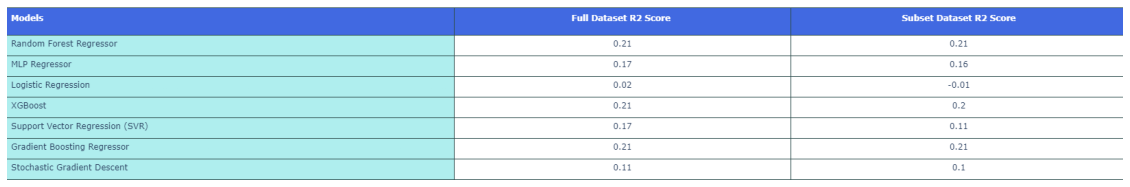

In [61]:
r2 = mpimg.imread('r2tab.png') 

plt.figure(figsize=(20,20))
plt.imshow(r2)
plt.axis('off')
plt.show()

The r2 was optmized at the Random Forest Regressor and the Gradient Boosting Regressor. The other methods did not achieve as high of scores. The MAE will now be considered to make the final decision between the two.

<font color='black'>
    <h3> MAE Table </h3>
</font>

In [197]:
values = [['Random Forest Regressor','MLP Regressor','Logistic Regression', 'XGBoost', 'Support Vector Regression (SVR)', 'Gradient Boosting Regressor', 'Stochastic Gradient Descent'], #1st col
  [round(mean_absolute_error(y_test, rf.predict(Xmod_test)),2) ,
    round(mean_absolute_error(y_test, mlp.predict(Xmod_test)),2),
    round(mean_absolute_error(y_test, logreg_full.predict(Xmod_test)),2),
    round(mean_absolute_error(y_test, xgbr_full.predict(Xmod_test)),2),
    round(mean_absolute_error(y_test, svm.predict(Xscale_test)),2),
    round(mean_absolute_error(y_test, gradBoost.predict(Xmod_test)),2),
    round(mean_absolute_error(y_test, sgd.predict(Xmod_test)),2)],
    [round(mean_absolute_error(y_test, sub_rf.predict(sub_X_test)),2) ,
    round(mean_absolute_error(y_test, sub_mlp.predict(sub_X_test)),2),
    round(mean_absolute_error(y_test, logreg_sub.predict(sub_X_test)),2),
    round(mean_absolute_error(y_test, xgbr_sub.predict(sub_X_test)),2),
    round(mean_absolute_error(y_test, sub_svm.predict(sub_Xscale_test)),2),
    round(mean_absolute_error(y_test, sub_gradBoost.predict(sub_X_test)),2),
    round(mean_absolute_error(y_test, sub_sgd.predict(sub_X_test)),2)]]

fig = go.Figure(data=[go.Table(
  columnorder = [1,2,3],
  columnwidth = [400,300,300],
  header = dict(
    values = [['<b>Models</b>'],
                  ['<b>Full Dataset MAE </b>'],['<b>Subset Dataset MAE</b>']]    ,
    line_color='darkslategray',
    fill_color='royalblue',
    align=['left','center'],
    font=dict(color='white', size=12),
    height=40
  ),
  cells=dict(
    values=values,
    line_color='darkslategray',
    fill=dict(color=['paleturquoise', 'white']),
    align=['left', 'center'],
    font_size=12,
    height=30)
    )
])
fig.show()

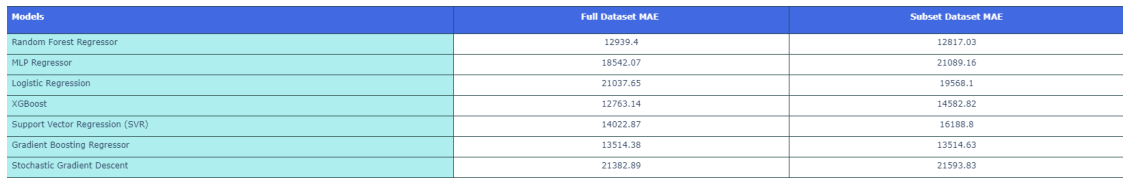

In [60]:
mae = mpimg.imread('maetable.png') 

plt.figure(figsize=(20,20))
plt.imshow(mae)
plt.axis('off')
plt.show()

The MAE was optimized at the Random forest subset between the two potential models above. Additionally the subset data will make the deployment of the app easier as the users would have to input less values to get their prediction at about the same accuracy as all values. That is why below the Random Forest subset model will be downloaded via pickle for deployment on the India Rent Prediction Application via StreamLit. 

<font color='black'>
    <h3> Saving Final Models and Encoders for App Construction </h3>
</font>

In [191]:
data = {'model': sub_rf, 'le_areatype': le_areatype, 
        'le_arealocality': le_arealocality, 'le_city': le_city,
        'le_contact': le_contact, 'le_furnish': le_furnish}

with open('model_labelencode.pkl', 'wb') as file:
    pickle.dump(data, file)

## Final Business Conclusion

The company MagicBricks would like to add an application for consumers that estimates rental costs of potential listings based off of the listing's description. Many regression techniques have been deployed including tree based ensembles like Random Forest and Gradient Boosting to more simplistic models like SGD and Logistic Regression. By our primary metrics, r2 and MAE, the subset dataset with Random Forest Regressor performed the best. The model miss predicted by an average of about 12000 rupees or $150. This is about a 35% error for each prediction. The model also underpredicts rent pricing. Meaning if the model and a similar listing are around the same, the consumer can be assured that they are getting a solid price. This error percentage fairly strong in this regression setting given that we are limited by the amount of information a consumer would be willing to put into a deployed application. Using the six variables chosen we were able to build and deploy an application that can give customers within 12000 rupee estimate without having too many inputs to make customers wary of using the estimator themselves. I would suggest to MagicBricks the deployment of this model on their website, as the model will only continue to improve as this dataset contained only 5,000 variables. 